In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm

import matplotlib.pyplot as plt

In [2]:
total_time = np.arange(np.datetime64("2022-06"), np.datetime64("2024-03"), dtype="datetime64[M]")

## Voting

In [3]:
def vote(ground_truth, result, thida):
    final = [[], []] # [groundtruth, predict]
    for k in ground_truth.keys():
        k_pre = result[result["post_time"] == k]["predict"].tolist()
        if len(k_pre) > 0:
            avg = sum(k_pre) / len(k_pre)
            if avg > thida:
                final[1].append(1)
            elif avg < -thida:
                final[1].append(-1)
            else:
                final[1].append(0)

            final[0].append(ground_truth[k])
            accuracy = metrics.accuracy_score(final[0], final[1])
    return final, accuracy

## Requirement(2) 
- 80% training data
- 20% testing data

In [40]:
data = pd.read_csv("yuanta_vector.csv")
data = data.drop(index=data[data["label"] == 0].index)
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 0:20172], data.iloc[:, 20172], test_size=0.2, random_state=13)

In [5]:
rbf80 = svm.SVC(kernel="rbf", C=5)
rbf80.fit(X_train, y_train)
predict = rbf80.predict(X_test)
rbf80_result = predict.tolist()

accuracy = metrics.accuracy_score(y_test, rbf80_result)
print("acc: " + str(accuracy))

acc: 0.5742411812961444


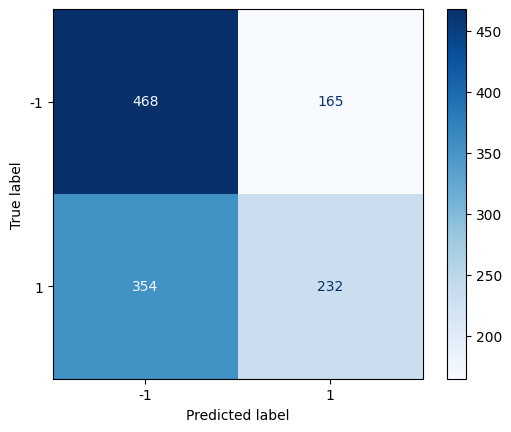

In [7]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, rbf80_result, cmap=plt.cm.Blues)
plt.show()

## Requirement(3) 移動回測

In [4]:
svc_result = pd.DataFrame()
ground_truth = {}
for m in total_time:
    # retrieve data
    train = pd.read_csv("output/" + str(m) + "/train.csv")
    train = train.drop(index=train[train["label"] == 0].index)
    test = pd.read_csv("output/" + str(m) + "/test.csv")
    test = test.drop(index=test[test["label"] == 0].index)

    # train & test data
    X_train = train.iloc[:, 0:len(train.columns)-2]
    y_train = train.iloc[:, len(train.columns)-2]
    X_test = test.iloc[:, 0:len(train.columns)-2]
    # y_test = test.iloc[:, len(train.columns)-2]

    # ground truth
    time_test = sorted(set(test.iloc[:, len(train.columns)-1]))
    for t in time_test:
        ground_truth[t] = set(test[test["post_time"] == t]["label"]).pop()

    # classification model
    svc = svm.SVC(kernel="rbf", C=5, decision_function_shape='ovr', degree=3)
    svc.fit(X_train, y_train)
    predict = svc.predict(X_test)

    # save predict
    temp_result = pd.DataFrame()
    temp_result["post_time"] = test["post_time"]
    temp_result["predict"] = predict
    svc_result = pd.concat([svc_result, temp_result], axis=0)
    
    print(m)

2022-06
2022-07
2022-08
2022-09
2022-10
2022-11
2022-12
2023-01
2023-02
2023-03
2023-04
2023-05
2023-06
2023-07
2023-08
2023-09
2023-10
2023-11
2023-12
2024-01
2024-02


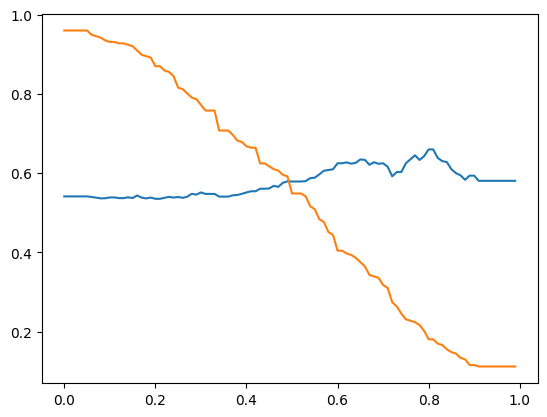

In [5]:
th_list = []
acc_list = []
act_list = []
for th in range(0, 100):
    th_list.append(th/100)
    f, acc = vote(ground_truth, svc_result, th/100)
    # print(acc)
    conf = metrics.confusion_matrix(f[0], f[1])
    act = (conf[0][0] + conf[1][0] + conf[2][0] + conf[0][2] + conf[1][2] + conf[2][2]) / (conf[0][0] + conf[1][0] + conf[2][0] + conf[0][1] + conf[1][1] + conf[2][1] + conf[0][2] + conf[1][2] + conf[2][2])
    newacc = (conf[0][0] + conf[2][2]) / (conf[0][0]+conf[0][2]+conf[2][0]+conf[2][2])
    acc_list.append(newacc)
    act_list.append(act)

plt.plot(th_list, acc_list, th_list, act_list)
plt.show()

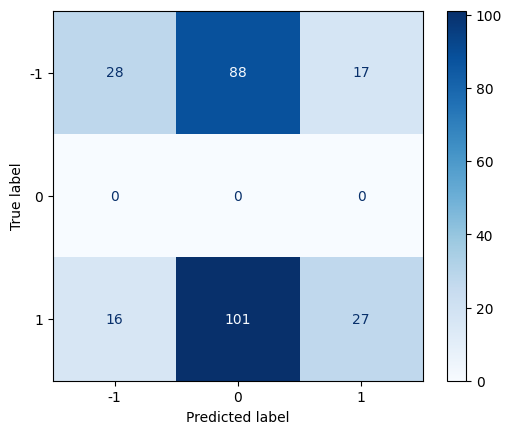

In [9]:
f, acc = vote(ground_truth, svc_result, 0.7)
conf = metrics.confusion_matrix(f[0], f[1])

metrics.ConfusionMatrixDisplay.from_predictions(f[0], f[1], cmap=plt.cm.Blues)
plt.show()

In [10]:
act = (conf[0][0] + conf[1][0] + conf[2][0] + conf[0][2] + conf[1][2] + conf[2][2]) / (conf[0][0] + conf[1][0] + conf[2][0] + conf[0][1] + conf[1][1] + conf[2][1] + conf[0][2] + conf[1][2] + conf[2][2])
newacc = (conf[0][0] + conf[2][2]) / (conf[0][0]+conf[0][2]+conf[2][0]+conf[2][2])
print("Accuracy: ", newacc)
print("Act", act)

Accuracy:  0.625
Act 0.3176895306859206


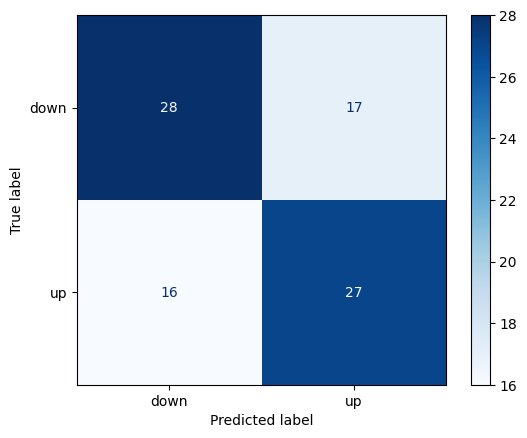

In [12]:
i = 0
while i < len(f[0]):
    if f[0][i] == 0 or f[1][i] == 0:
        del f[0][i]
        del f[1][i]
        i -= 1
    i += 1

metrics.ConfusionMatrixDisplay.from_predictions(f[0], f[1], display_labels=["down", "up"], cmap=plt.cm.Blues)
plt.show()